In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel
from torchts.nn.models.seq2seq import Encoder, Decoder, Seq2Seq 

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Generate dataset

In [2]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
data = pd.read_csv("data.csv")
# x = np.linspace(0, 735, 736).reshape(-1, 1).astype(np.float32)

xx = np.linspace(0,729,730).reshape(-1,1).astype(np.float32)
yy = data.Num_Flights[0:730].values.reshape(-1, 1).astype(np.float32)

x = NormalizeData(xx)
y = NormalizeData(yy)

No handles with labels found to put in legend.


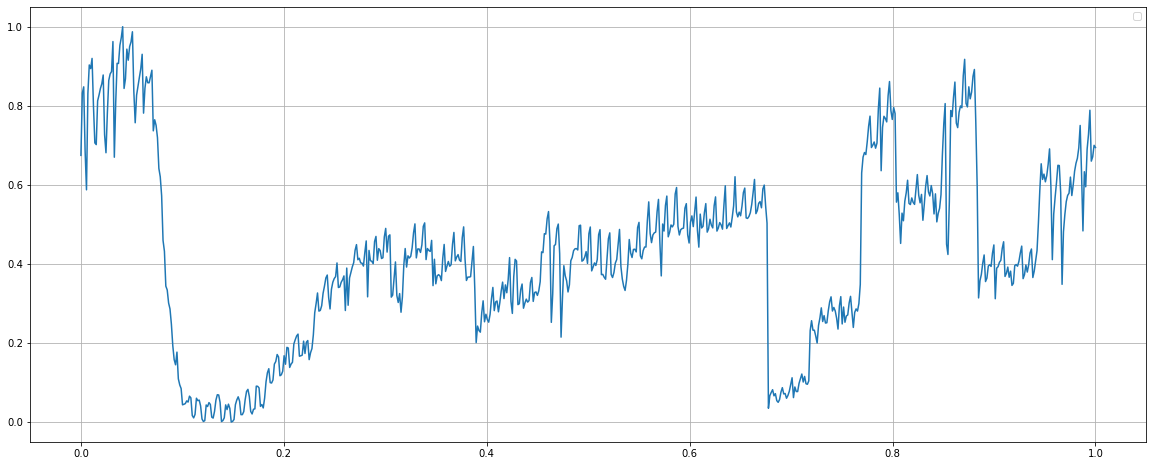

In [5]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(x, y)
plt.legend()
plt.show()

# Enable uncertainty quantification in LSTM model

In [6]:
class LSTM(TimeSeriesModel):
    def __init__(self, input_size, output_size, optimizer, hidden_size=8, batch_size=10, **kwargs):
        super(LSTM, self).__init__(optimizer, **kwargs)
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.lstm = torch.nn.LSTMCell(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        # initialize the hidden state and the cell state to zeros
        return (torch.zeros(self.batch_size, self.hidden_size),
                torch.zeros(self.batch_size, self.hidden_size))

    def forward(self, x, y=None, batches_seen=None):
        hc = self.init_hidden()
        
        hidden, _ = self.lstm(x, hc)
        out = self.linear(hidden)
        return out

In [7]:
inputDim = 1       
outputDim = 1 
optimizer_args = {"lr": 0.01}
quantiles = [0.025, 0.5, 0.975]

batch_size = 10
models = {quantile: LSTM(
    inputDim, 
    outputDim, 
    torch.optim.Adam,
    criterion=quantile_loss, 
    criterion_args={"quantile": quantile}, 
    optimizer_args=optimizer_args
    ) for quantile in quantiles}

In [8]:
for _, model in models.items():
    # train model
    model.fit(
        torch.from_numpy(x),
        torch.from_numpy(y),
        max_epochs=100,
        batch_size=batch_size,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\yanbo\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)
C:\Users\yanbo\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [9]:
# inference
y_preds = {}
for x_batch in torch.split(torch.from_numpy(x), batch_size):
    for q, model in models.items():
        if q not in y_preds:
            y_preds[q] = [model.predict(x_batch).detach().numpy()]
        else:
            y_preds[q].append(model.predict(x_batch).detach().numpy())
y_preds = {q: np.concatenate(y_pred) for q, y_pred in y_preds.items()}

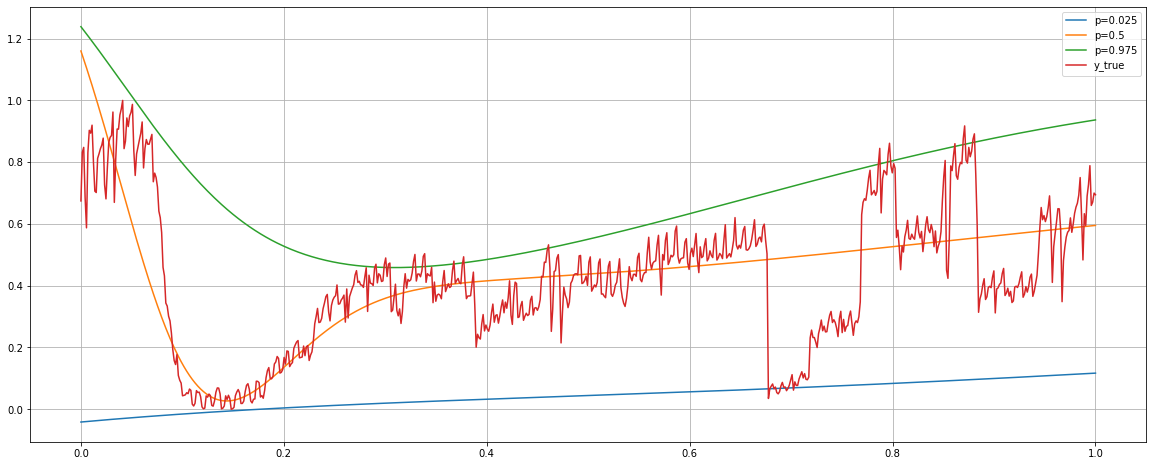

In [10]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.plot(x.flatten(), y_preds[0.025].flatten(), label="p=0.025")
plt.plot(x.flatten(), y_preds[0.5].flatten(), label="p=0.5")
plt.plot(x.flatten(), y_preds[0.975].flatten(), label="p=0.975")
plt.plot(x.flatten(), y.flatten(), label="y_true")
plt.legend()
plt.show()